Using cpu device
image.shape torch.Size([1, 3, 96, 96])
image.shape torch.Size([1, 3, 96, 96])
predicted_heatmaps.shape torch.Size([24, 96, 96])
{'image': tensor([[[112, 112, 108,  ..., 125, 127, 128],
         [127, 127, 124,  ..., 113, 113, 115],
         [132, 131, 130,  ...,  95,  95,  96],
         ...,
         [109, 106, 104,  ...,  97, 114, 121],
         [102, 103, 108,  ..., 107, 114, 115],
         [ 91,  94, 103,  ..., 121, 122, 111]],

        [[114, 114, 109,  ..., 128, 129, 131],
         [129, 129, 125,  ..., 116, 117, 119],
         [133, 132, 130,  ..., 101, 101, 102],
         ...,
         [103,  99,  95,  ...,  78,  96, 103],
         [ 95,  95,  99,  ...,  91,  99,  99],
         [ 80,  83,  93,  ..., 106, 108,  98]],

        [[ 77,  75,  72,  ..., 104, 106, 107],
         [ 94,  93,  90,  ...,  82,  82,  84],
         [ 99,  98,  96,  ...,  55,  54,  55],
         ...,
         [ 49,  45,  42,  ...,  50,  70,  78],
         [ 46,  47,  51,  ...,  62,  70,  72],


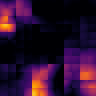

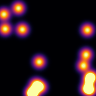

In [1]:
import sys;sys.path.insert(0, '..')
from matplotlib import colormaps
import torch
import torch.nn as nn
import os
from src.FCN8 import FCN8
import src.core as core
import src.guassian as guassian
import torchvision
import matplotlib.pyplot as plt
from src.image import add_keypoints
from src.keypoints import get_keypoint_definitions

cm = colormaps['inferno']
cwd = os.getcwd()
FCN8_model_dir = os.path.join(cwd, '..', 'models', 'FNC8_FINAL')

run_dir = os.path.join(FCN8_model_dir, 'run')
model_dir = os.path.join(FCN8_model_dir, 'model')


print(f"Using {core.TorchDevice} device")
torch.set_default_device(core.TorchDevice)

loaded_model = FCN8()
saved_model_path = model_path = os.path.join(model_dir, f'model_20240405_093356_53')
checkpoint = torch.load(saved_model_path, map_location=core.TorchDevice)
loaded_model.load_state_dict(checkpoint)
loaded_model.eval()

image_index = 1100

predicted_heatmaps = None
single_sample = None
for i, sample in enumerate(core.TestDataSet):
    if (i == image_index):
        single_sample = sample
        image, heatmaps = sample
        image, heatmaps = image.to(core.TorchDevice).unsqueeze(0), heatmaps.to(core.TorchDevice)

        print("image.shape", image.shape)

        print(f"image.shape {image.shape}")
        predicted_heatmaps = loaded_model(image)
        predicted_heatmaps = predicted_heatmaps.squeeze(0)

        print("predicted_heatmaps.shape", predicted_heatmaps.shape)



        break
singe_image = None
for i, sample in enumerate(core.TestDataSetNoNormalization):
    if (i == image_index):
        print(sample)
        singe_image = sample["image"]

        break


print(f"Predicted class: {predicted_heatmaps.shape}")

pred_heatmaps = predicted_heatmaps.cpu().detach()

predicted_keypoints = guassian.heatmaps_to_keypoints_CoM(pred_heatmaps)

image, gt_heatmaps = single_sample

ground_heatmaps = gt_heatmaps.cpu().detach()

gt_keypoints = guassian.heatmaps_to_keypoints_CoM(ground_heatmaps)

print(gt_keypoints)
print(predicted_keypoints)

## Create a single summed heatmap for 
pred_joined_heatmap = pred_heatmaps.sum(dim=0)


pred_joined_color_heatmap = cm(pred_joined_heatmap)

display(torchvision.transforms.functional.to_pil_image(pred_joined_color_heatmap))


## Create a single summed heatmap for 
ground_joined_heatmap = ground_heatmaps.sum(dim=0)


ground_joined_color_heatmap = cm(ground_joined_heatmap)

display(torchvision.transforms.functional.to_pil_image(ground_joined_color_heatmap))


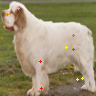

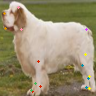

In [2]:



keypoint_defs = get_keypoint_definitions('../data/annotations/keypoint_definitions.csv')
keypoint_colors = keypoint_defs['colors']

predicted_keypoints_with_visible = []
ground_keypoints_with_visible = []

for i, k in enumerate(predicted_keypoints):
    gt_k = gt_keypoints[i]
    x, y = k
    gt_x, gt_y = gt_k
    visible = 1

    if (gt_x == 0 and gt_y == 0):
        visible = 0

    predicted_keypoints_with_visible.append([x, y, visible])
    ground_keypoints_with_visible.append([gt_x, gt_y, visible])

image_with_keypoints = add_keypoints(singe_image, keypoints=predicted_keypoints_with_visible, colors=keypoint_colors, skip_visible=True)
display(torchvision.transforms.functional.to_pil_image(image_with_keypoints))

image_with_gt_keypoints = add_keypoints(singe_image, keypoints=ground_keypoints_with_visible, colors=keypoint_colors, skip_visible=True)
display(torchvision.transforms.functional.to_pil_image(image_with_gt_keypoints))